# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import imageio
from imageio.v2 import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator


In [2]:
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [3]:
print(tf.__version__)
print(keras.__version__)

2.12.0
2.12.0


In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 64 #experiment with the batch size
num_classes = 5


print(f'Train length: {len(train_doc)}')
print(f'Validation length: {len(val_doc)}')

Train length: 663
Validation length: 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def preprocess_image(image, channel, height, width):
    image = resize_image(image, height, width)
    return normalise_image(image, channel)

In [7]:
def normalise_image(image, channel):
    return (image[...,channel])/255

In [8]:
def resize_image(image, height, width):
    h, w, c = image.shape
    return resize(image, (height, width), anti_aliasing=True)

In [9]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 120, 120, 3]

In [10]:
def generate_common(t, source_path, batch_size, img_idx, batch, batch_data, batch_labels, height=120, width=120, augment=False):
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            

            # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
            if augment:
                image = resize_image(image, height, width)
                if np.random.randn() > 0:
                    image = datagen.random_transform(image)                   

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            
            batch_data[folder,idx,:,:,0] = preprocess_image(image, 0, height, width) #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = preprocess_image(image, 1, height, width) #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = preprocess_image(image, 2, height, width) #normalise and feed in the image                  
            
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

    return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [11]:
# Kept default height and width to 120x120
def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

            yield generate_common(t, source_path, batch_size, img_idx, batch, batch_data, batch_labels, height, width)
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            yield generate_common(t, source_path, remaining_batch_size, img_idx, num_batches, batch_data, batch_labels, height, width)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


#### Validating the Generator

In [14]:
# check complete batch shape
sample_generator = generate(train_path, train_doc, batch_size)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generate(val_path, val_doc, batch_size)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

(64, 20, 120, 120, 3)
(64, 20, 120, 120, 3)


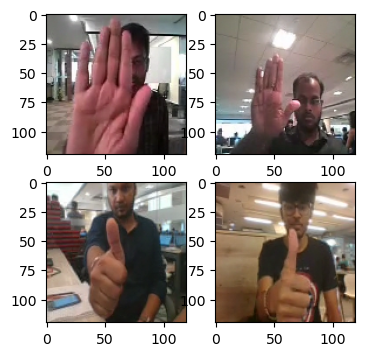

In [15]:
fig, ax = plt.subplots(2,2, figsize=(4,4))
ax[0,0].imshow(sample_batch_data[16,10,:,:,:])   
ax[0,1].imshow(sample_batch_data[25,10,:,:,:])

ax[1,0].imshow(sample_val_batch_data[16,10,:,:,:])   
ax[1,1].imshow(sample_val_batch_data[25,10,:,:,:])
plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [16]:
from keras.models import Sequential, Model
from keras.layers import  Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

Model callback utility

In [30]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())

    # fig, ax = plt.subplots(1,2, figsize=(16,8))
    
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [18]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]

In [19]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [20]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

#### Model 1: 
Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [21]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 20
# batch size = 60
# num_frames per video = 30
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                              

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [22]:
callbacks_list = model_callbacks("model_30_conv3D_1")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [23]:
history = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, 
                    verbose=1,        
                    callbacks=callbacks_list, 
                    validation_data=val_generator,          
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    workers=1, 
                    initial_epoch=0)

Epoch 1/20


2024-04-28 13:56:34.359182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-28 13:56:34.361937: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


12/12 [==============================] - ETA: 0s - loss: 1.5279 - categorical_accuracy: 0.4646 

2024-04-28 14:00:18.759414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 5.40293, saving model to model_30_conv3D_1_2024-04-2813_54_34.860572/model-00001-1.52795-0.46456-5.40293-0.23000.h5
12/12 [==============================] - 257s 22s/step - loss: 1.5279 - categorical_accuracy: 0.4646 - val_loss: 5.4029 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 1.0322 - categorical_accuracy: 0.6078 
Epoch 2: val_loss did not improve from 5.40293
12/12 [==============================] - 587s 52s/step - loss: 1.0322 - categorical_accuracy: 0.6078 - val_loss: 8.0512 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 1.0267 - categorical_accuracy: 0.6169 
Epoch 3: val_loss did not improve from 5.40293
12/12 [==============================] - 253s 22s/step - loss: 1.0267 - categorical_accuracy: 0.6169 - val_loss: 5.6153 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 4/20
12/12 [==============

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


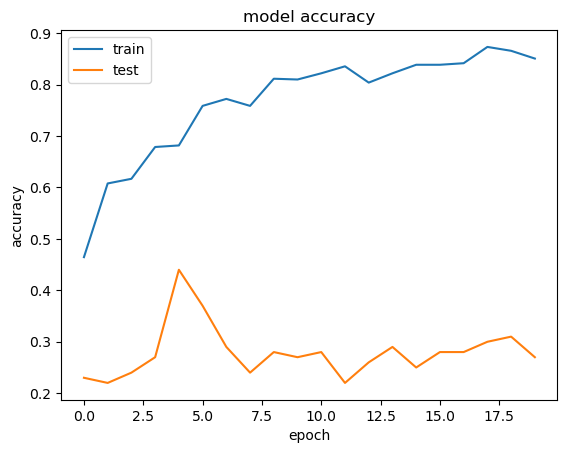

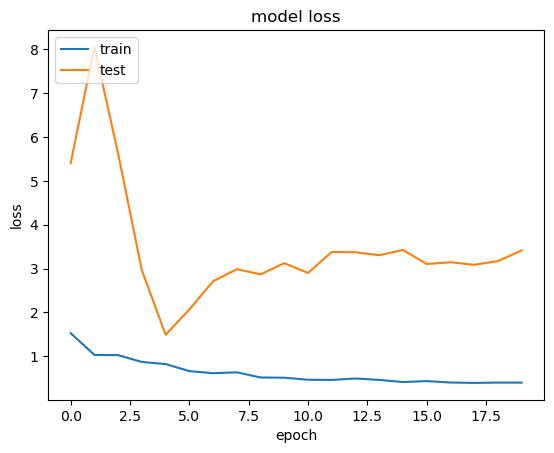

In [31]:
plot_loss_accuracy(history)

#### Model 2: 
Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)¶

In [32]:
num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)

model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 activat

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [33]:
callbacks_list = model_callbacks("model_20_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [34]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


2024-04-28 16:00:56.753192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


67/67 [==============================] - ETA: 0s - loss: 1.6021 - categorical_accuracy: 0.4480

2024-04-28 16:03:19.167183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2.65154, saving model to model_20_conv3D_2_2024-04-2813_54_34.860572/model-00001-1.60212-0.44796-2.65154-0.21000.h5
67/67 [==============================] - 165s 2s/step - loss: 1.6021 - categorical_accuracy: 0.4480 - val_loss: 2.6515 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0868 - categorical_accuracy: 0.5897
Epoch 2: val_loss did not improve from 2.65154
67/67 [==============================] - 162s 2s/step - loss: 1.0868 - categorical_accuracy: 0.5897 - val_loss: 3.0373 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.8966 - categorical_accuracy: 0.6576
Epoch 3: val_loss did not improve from 2.65154
67/67 [==============================] - 161s 2s/step - loss: 0.8966 - categorical_accuracy: 0.6576 - val_loss: 4.9197 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 4/20
67/67 [===================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


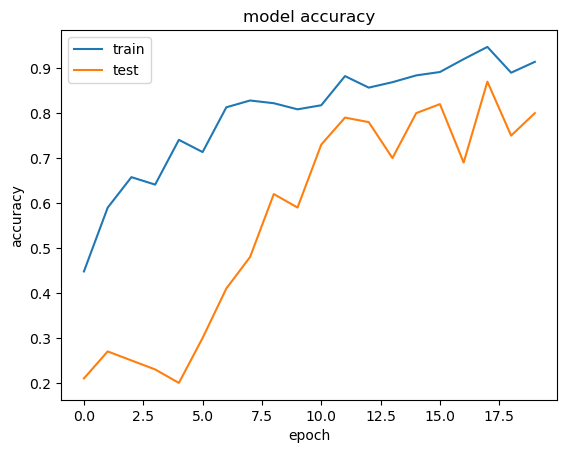

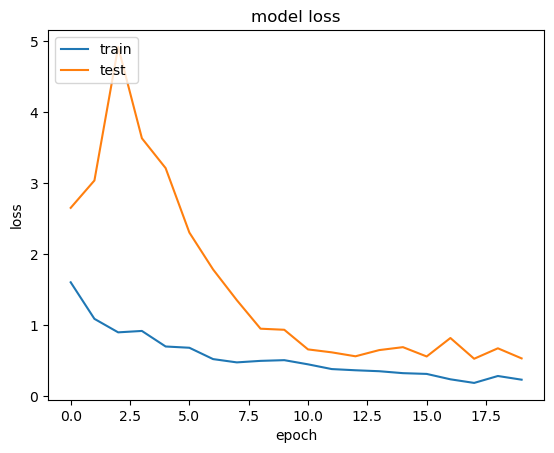

In [35]:
plot_loss_accuracy(history)

#### Model 3: 
Conv 3D Model with 30 frames per video (32, 64, 128, 256) filters conv 3D layers + 128 dense layer + 128 dense layer + image size 120 by 120)

In [36]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)

conv_filters = (32, 64, 128, 256)
dense_filters = (128, 128)
model = conv3D(conv_filters=conv_filters,dense_nodes=dense_filters, num_images=num_frames)
print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 30
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 32)  2624      
                                                                 
 activation_14 (Activation)  (None, 30, 120, 120, 32)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 60, 60, 64)    55360     
                                                            

In [37]:
callbacks_list = model_callbacks("model_30_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [38]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


2024-04-28 16:58:32.205733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


67/67 [==============================] - ETA: 0s - loss: 1.6586 - categorical_accuracy: 0.4118

2024-04-28 17:03:55.724794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 4.42729, saving model to model_30_conv3D_3_2024-04-2813_54_34.860572/model-00001-1.65856-0.41176-4.42729-0.18000.h5
67/67 [==============================] - 357s 5s/step - loss: 1.6586 - categorical_accuracy: 0.4118 - val_loss: 4.4273 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.1430 - categorical_accuracy: 0.5716
Epoch 2: val_loss did not improve from 4.42729
67/67 [==============================] - 354s 5s/step - loss: 1.1430 - categorical_accuracy: 0.5716 - val_loss: 7.4116 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.9865 - categorical_accuracy: 0.6033
Epoch 3: val_loss did not improve from 4.42729
67/67 [==============================] - 354s 5s/step - loss: 0.9865 - categorical_accuracy: 0.6033 - val_loss: 4.6064 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 4/20
67/67 [===================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


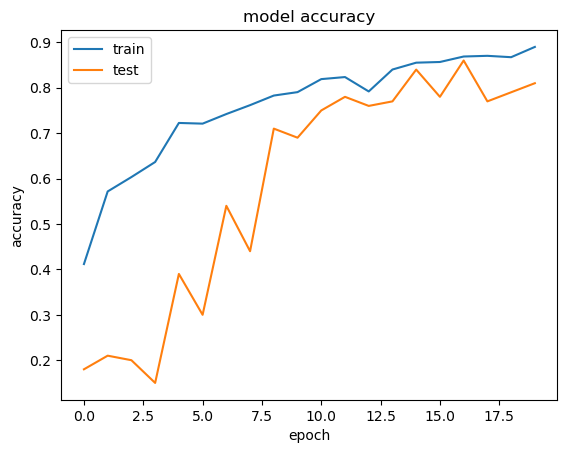

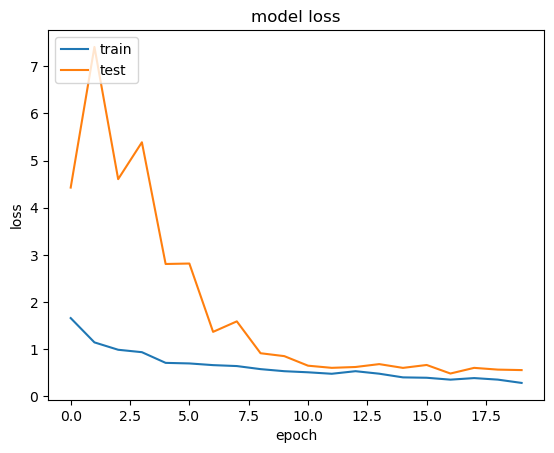

In [39]:
plot_loss_accuracy(history)

#### Model 4: 
Conv 3D Model with 20 frames per video (32, 64, 128, 256) filters conv 3D layers + 128 dense layer + 128 dense layer + image size 120 by 120)

In [40]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)

conv_filters = (32, 64, 128, 256)
dense_filters = (128, 128)
model = conv3D(conv_filters=conv_filters,dense_nodes=dense_filters, num_images=num_frames)
print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 120, 120, 32)  2624      
                                                                 
 activation_21 (Activation)  (None, 20, 120, 120, 32)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 20, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 60, 60, 64)    55360     
                                                            

In [41]:
callbacks_list = model_callbacks("model_20_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [42]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


2024-04-28 18:56:56.797560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


67/67 [==============================] - ETA: 0s - loss: 1.6646 - categorical_accuracy: 0.4148

2024-04-28 19:00:37.368252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2.26604, saving model to model_20_conv3D_3_2024-04-2813_54_34.860572/model-00001-1.66463-0.41478-2.26604-0.14000.h5
67/67 [==============================] - 243s 4s/step - loss: 1.6646 - categorical_accuracy: 0.4148 - val_loss: 2.2660 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.2046 - categorical_accuracy: 0.5385
Epoch 2: val_loss did not improve from 2.26604
67/67 [==============================] - 238s 4s/step - loss: 1.2046 - categorical_accuracy: 0.5385 - val_loss: 2.4123 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.0985 - categorical_accuracy: 0.5792
Epoch 3: val_loss did not improve from 2.26604
67/67 [==============================] - 240s 4s/step - loss: 1.0985 - categorical_accuracy: 0.5792 - val_loss: 4.0377 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 4/20
67/67 [===================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


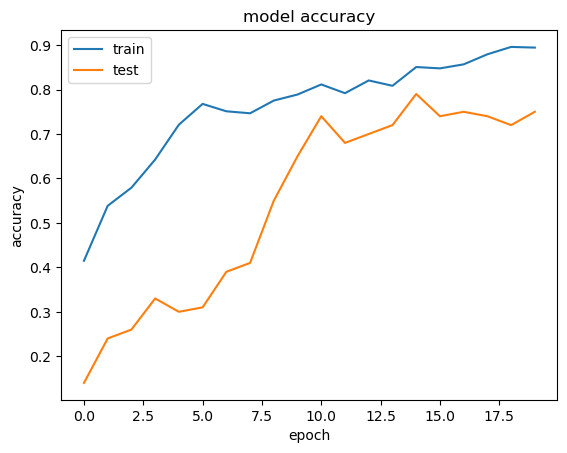

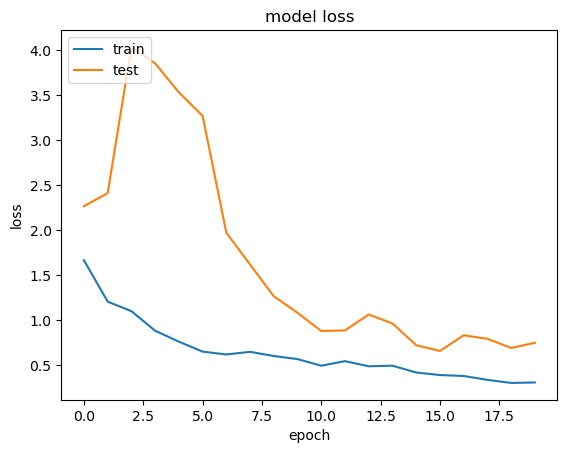

In [43]:
plot_loss_accuracy(history)

### TRANSFER LEARNING - MobileNet Conv2d + GRU

In [44]:
from keras.applications import mobilenet

def mobilenet_RNN_GRU_LSTM((fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(keras.layers.MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model

#### Model 5: 
Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes

In [45]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)

model = mobilenet_RNN_GRU_LSTM((gru=True, num_images=num_frames)
print (model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20


Number of layers in the pretrained mobilenet model:  86


2024-04-28 20:35:40.631977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-28 20:35:40.632453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-28 20:35:40.632866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)              

In [46]:
callbacks_list = model_callbacks("model_20_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [47]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


2024-04-28 20:35:42.413902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-28 20:35:42.615376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-28 20:35:42.616094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

67/67 [==============================] - ETA: 0s - loss: 1.2130 - categorical_accuracy: 0.4902

2024-04-28 20:38:16.017192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-28 20:38:16.192813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-28 20:38:16.193375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra


Epoch 1: val_loss improved from inf to 1.30865, saving model to model_20_retrain_mobilenet_gru_2024-04-2813_54_34.860572/model-00001-1.21299-0.49020-1.30865-0.47000.h5
67/67 [==============================] - 176s 3s/step - loss: 1.2130 - categorical_accuracy: 0.4902 - val_loss: 1.3086 - val_categorical_accuracy: 0.4700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.6382 - categorical_accuracy: 0.7421
Epoch 2: val_loss improved from 1.30865 to 0.46922, saving model to model_20_retrain_mobilenet_gru_2024-04-2813_54_34.860572/model-00002-0.63824-0.74208-0.46922-0.76000.h5
67/67 [==============================] - 176s 3s/step - loss: 0.6382 - categorical_accuracy: 0.7421 - val_loss: 0.4692 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.4867 - categorical_accuracy: 0.8160
Epoch 3: val_loss did not improve from 0.46922
67/67 [==============================] - 178s 3s/step - loss: 0.48

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


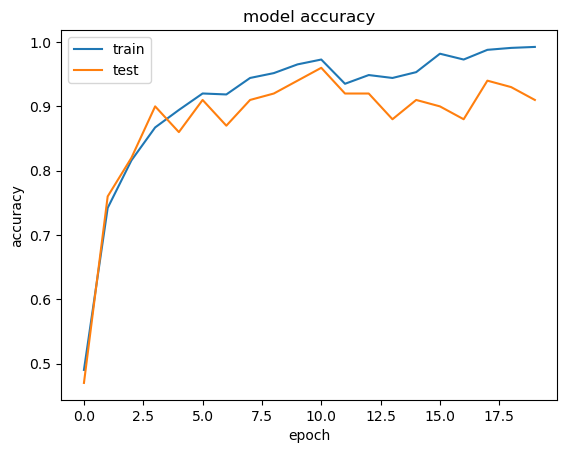

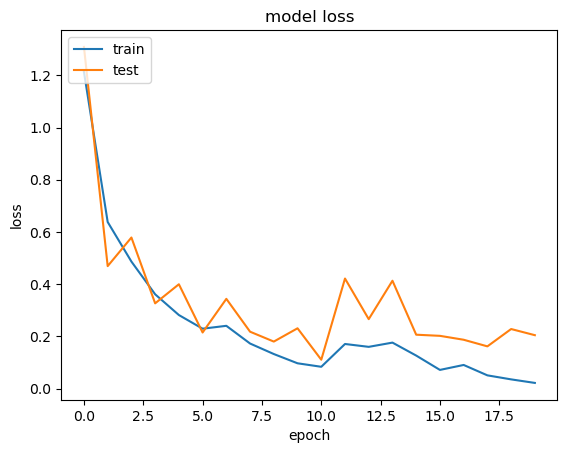

In [48]:
plot_loss_accuracy(history)

#### Model 6: 
Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set

In [49]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)

model = mobilenet_RNN_GRU_LSTM((gru=True, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 30


Number of layers in the pretrained mobilenet model:  86


2024-04-28 21:34:28.436336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-28 21:34:28.436830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-28 21:34:28.437247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 30, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 30, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [50]:
callbacks_list = model_callbacks("model_30_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [51]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


2024-04-28 21:34:31.637966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-28 21:34:31.844586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-28 21:34:31.845219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

67/67 [==============================] - ETA: 0s - loss: 1.3194 - categorical_accuracy: 0.4525

2024-04-28 21:38:21.033453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-28 21:38:21.206804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-28 21:38:21.207313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra


Epoch 1: val_loss improved from inf to 0.91868, saving model to model_30_retrain_mobilenet_gru_2024-04-2813_54_34.860572/model-00001-1.31938-0.45249-0.91868-0.71000.h5
67/67 [==============================] - 262s 4s/step - loss: 1.3194 - categorical_accuracy: 0.4525 - val_loss: 0.9187 - val_categorical_accuracy: 0.7100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.6352 - categorical_accuracy: 0.7617
Epoch 2: val_loss improved from 0.91868 to 0.59195, saving model to model_30_retrain_mobilenet_gru_2024-04-2813_54_34.860572/model-00002-0.63517-0.76169-0.59195-0.74000.h5
67/67 [==============================] - 259s 4s/step - loss: 0.6352 - categorical_accuracy: 0.7617 - val_loss: 0.5919 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.4279 - categorical_accuracy: 0.8462
Epoch 3: val_loss improved from 0.59195 to 0.43263, saving model to model_30_retrain_mobilenet_gru_2024-04-2813_5

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


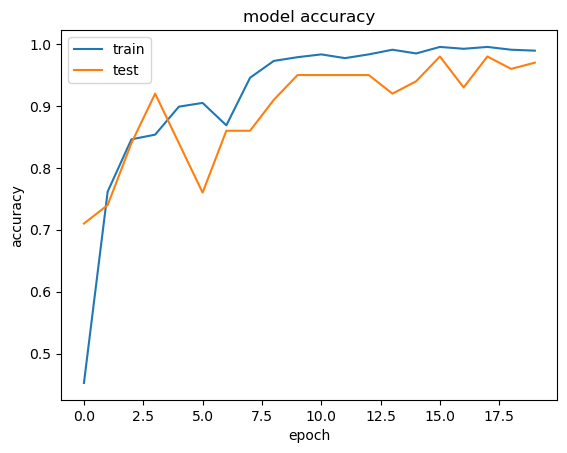

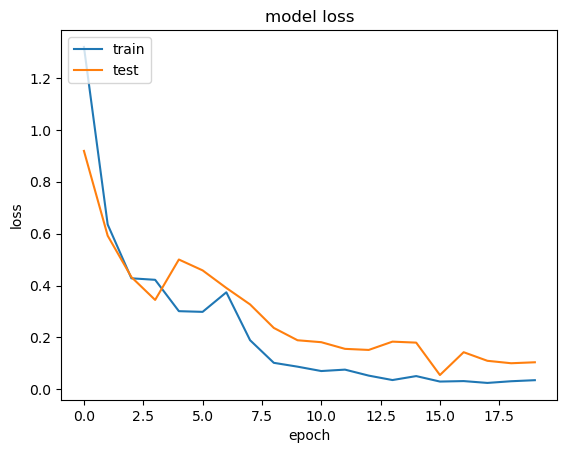

In [52]:
plot_loss_accuracy(history)

#### Model 7: 
Mobilenet 20 frames (re train all wieghts) + LSTM (128 cells) + 128 dense nodes

In [53]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)

model = mobilenet_RNN_GRU_LSTM((gru=False, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20


Number of layers in the pretrained mobilenet model:  86


2024-04-28 23:01:37.165874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-28 23:01:37.166282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-28 23:01:37.166802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 20, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)              

In [54]:
callbacks_list = model_callbacks("model_20_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [55]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


2024-04-28 23:01:39.029818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-28 23:01:39.245896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-28 23:01:39.246591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

67/67 [==============================] - ETA: 0s - loss: 1.2173 - categorical_accuracy: 0.4857

2024-04-28 23:04:12.061169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-28 23:04:12.267601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-28 23:04:12.268306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra


Epoch 1: val_loss improved from inf to 1.21431, saving model to model_20_retrain_mobilenet_lstm_2024-04-2813_54_34.860572/model-00001-1.21734-0.48567-1.21431-0.61000.h5
67/67 [==============================] - 175s 3s/step - loss: 1.2173 - categorical_accuracy: 0.4857 - val_loss: 1.2143 - val_categorical_accuracy: 0.6100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.8716 - categorical_accuracy: 0.6456
Epoch 2: val_loss improved from 1.21431 to 0.70106, saving model to model_20_retrain_mobilenet_lstm_2024-04-2813_54_34.860572/model-00002-0.87163-0.64555-0.70106-0.75000.h5
67/67 [==============================] - 171s 3s/step - loss: 0.8716 - categorical_accuracy: 0.6456 - val_loss: 0.7011 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.7277 - categorical_accuracy: 0.7451
Epoch 3: val_loss improved from 0.70106 to 0.65306, saving model to model_20_retrain_mobilenet_lstm_2024-04-281

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


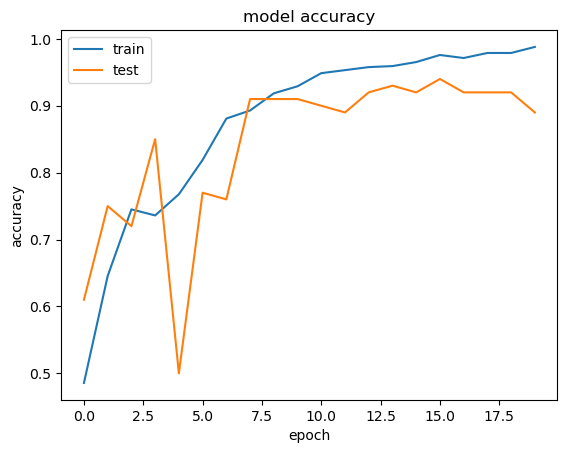

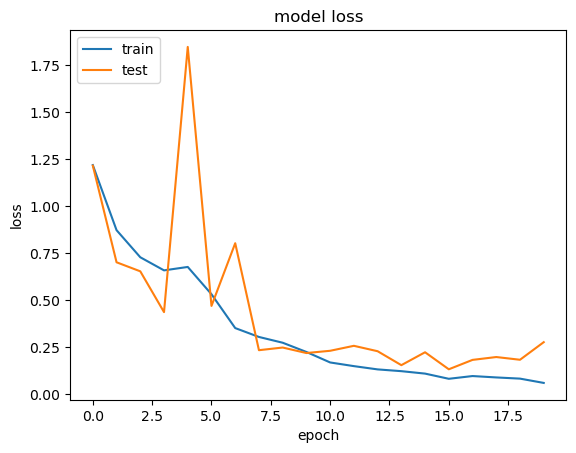

In [56]:
plot_loss_accuracy(history)

#### Model 8: 
Mobilenet 30 frames (re train all wieghts) + LSTM (128 cells) + 128 dense nodes

In [57]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)

model = mobilenet_RNN_GRU_LSTM((gru=False, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 30


Number of layers in the pretrained mobilenet model:  86


2024-04-28 23:59:12.137008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-28 23:59:12.137497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-28 23:59:12.137830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 30, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 30, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 30, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)              

In [58]:
callbacks_list = model_callbacks("model_30_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


2024-04-28 23:59:15.290832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-28 23:59:15.498139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-28 23:59:15.498729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

67/67 [==============================] - ETA: 0s - loss: 1.3210 - categorical_accuracy: 0.4540

2024-04-29 00:03:03.808212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-29 00:03:03.987778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-29 00:03:03.988215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra


Epoch 1: val_loss improved from inf to 0.95374, saving model to model_30_retrain_mobilenet_lstm_2024-04-2813_54_34.860572/model-00001-1.32095-0.45400-0.95374-0.59000.h5
67/67 [==============================] - 260s 4s/step - loss: 1.3210 - categorical_accuracy: 0.4540 - val_loss: 0.9537 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.8293 - categorical_accuracy: 0.6440
Epoch 2: val_loss improved from 0.95374 to 0.68677, saving model to model_30_retrain_mobilenet_lstm_2024-04-2813_54_34.860572/model-00002-0.82928-0.64404-0.68677-0.74000.h5
67/67 [==============================] - 262s 4s/step - loss: 0.8293 - categorical_accuracy: 0.6440 - val_loss: 0.6868 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.6826 - categorical_accuracy: 0.7330 
Epoch 3: val_loss did not improve from 0.68677
67/67 [==============================] - 827s 12s/step - loss: 

In [ ]:
plot_loss_accuracy(history)

### Load Selected Model
Loading the selected model from the disk 